In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from helpers.interpolate_extinction_coeffs import extinction_coeffs

In [2]:
wls, (water_ex, oxy_ex, deoxy_ex, lipid_ex) = extinction_coeffs()

with pm.Model() as skin_scalp:
    blood = pm.Uniform('blood', lower=1, upper=100)
    blood_sat = pm.Beta('blood_sat', alpha=5, beta=2)
    oxy = pm.Deterministic('oxy', blood_sat*blood)
    deoxy = pm.Deterministic('deoxy', (1 - blood_sat)*blood)

    lw_frac = pm.Beta('LW_frac', alpha=2, beta=5)
    w_over_lw_frac = pm.Beta('water_over_lipid_frac', alpha=2, beta=2)
    water_frac = pm.Deterministic('water_frac', lw_frac*w_over_lw_frac)
    lipid_frac = pm.Deterministic('lipid_frac', w_over_lw_frac - water_frac)
    m = pm.Uniform('m', lower=2.5, upper=3.5)
    mel_frac = pm.Uniform('mel_frac', lower=0, upper=0.025)
    
    mel_abs = pm.Deterministic('mel_abs', 519*mel_frac*(wls / 500)**(-m))
    water_abs = pm.Deterministic('water_abs', water_frac*55.5*water_ex)
    oxy_abs = pm.Deterministic('oxy_abs', oxy*oxy_ex*1e-6)
    deoxy_abs = pm.Deterministic('deoxy_abs', deoxy*deoxy_ex*1e-6)
    lipid_abs = pm.Deterministic('lipid_abs', lipid_frac*lipid_ex)
    absorption = pm.Deterministic('absorption',
        water_abs + oxy_abs + deoxy_abs + lipid_abs + mel_abs
    )

    a = pm.Uniform('a', lower=5, upper=60)
    b = pm.Uniform('b', lower=0.2, upper=3)

    scattering = pm.Deterministic('scattering',
        a*(wls/500.0)**(-b)
    )

In [3]:
with skin_scalp:
    prior = pm.sample_prior_predictive(samples=100)

Sampling: [LW_frac, a, b, blood, blood_sat, m, mel_frac, water_over_lipid_frac]


total absorption


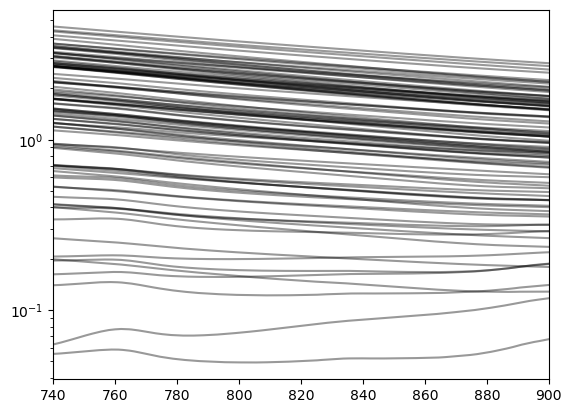

individual absorption


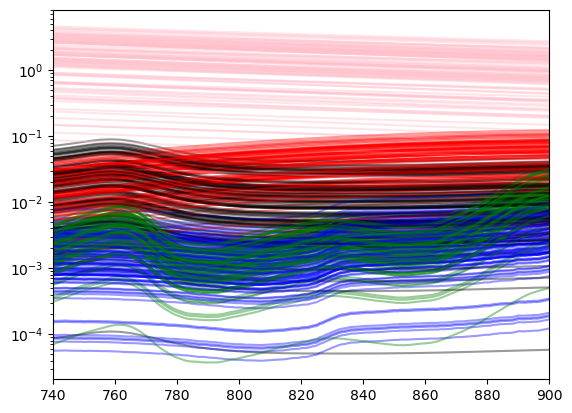

scattering


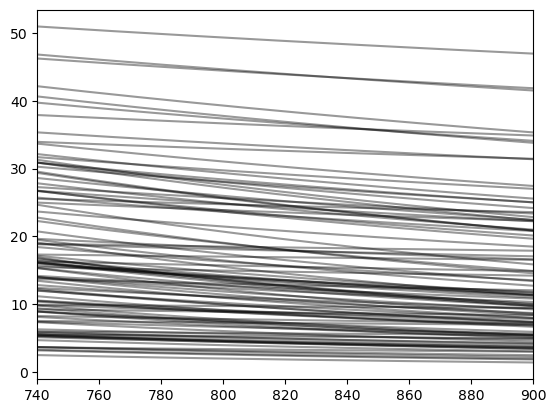

In [4]:
wl_range = (740, 900)
prior_abs = prior['prior'].absorption[0, ...]

print('total absorption')
plt.figure()
for row in prior_abs:
    plt.plot(wls, row, color='black', alpha=0.4)

plt.yscale('log')
plt.xlim(wl_range)
plt.show()

print('individual absorption')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].water_abs[0, i, :], color='blue', alpha=0.4)
    plt.plot(wls, prior['prior'].oxy_abs[0, i, :], color='red', alpha=0.4)
    plt.plot(wls, prior['prior'].deoxy_abs[0, i, :], color='black', alpha=0.4)
    plt.plot(wls, prior['prior'].lipid_abs[0, i, :], color='green', alpha=0.4)
    plt.plot(wls, prior['prior'].mel_abs[0, i, :], color='pink', alpha=0.4)
plt.xlim(wl_range)
plt.yscale('log')
plt.show()

print('scattering')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].scattering[0, i, :], color='black', alpha=0.4)
plt.xlim(wl_range)
plt.show()

individual absorption


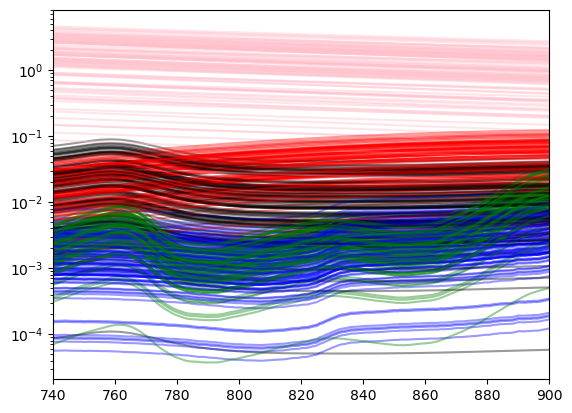

In [5]:
print('individual absorption')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].water_abs[0, i, :], color='blue', alpha=0.4)
    plt.plot(wls, prior['prior'].oxy_abs[0, i, :], color='red', alpha=0.4)
    plt.plot(wls, prior['prior'].deoxy_abs[0, i, :], color='black', alpha=0.4)
    plt.plot(wls, prior['prior'].lipid_abs[0, i, :], color='green', alpha=0.4)
    plt.plot(wls, prior['prior'].mel_abs[0, i, :], color='pink', alpha=0.4)
plt.xlim(wl_range)
plt.yscale('log')
plt.show()

In [22]:
print(max(zip(wls, deoxy_ex), key=lambda e: e[1]))

list(zip(wls, deoxy_ex))

(758.0701293945312, 1681.5591430664062)


[(740.0486450195312, 1341.4028161621093),
 (740.3311767578125, 1345.1943920898439),
 (740.6136474609375, 1348.9851489257812),
 (740.8961181640625, 1352.7759057617188),
 (741.1785278320312, 1356.8764819335938),
 (741.4610595703125, 1361.1596630859376),
 (741.743408203125, 1365.440068359375),
 (742.0258178710938, 1369.821055908203),
 (742.30810546875, 1375.190166015625),
 (742.5904541015625, 1380.5604370117187),
 (742.8727416992188, 1385.9295471191406),
 (743.1549682617188, 1391.3114434814452),
 (743.4371948242188, 1396.7047930908202),
 (743.7193603515625, 1402.0969763183593),
 (744.0016479492188, 1407.491278076172),
 (744.2837524414062, 1412.8456213378906),
 (744.56591796875, 1418.201123046875),
 (744.8479614257812, 1423.5543078613282),
 (745.1300048828125, 1429.466513671875),
 (745.4120483398438, 1436.0324853515626),
 (745.6940307617188, 1442.5970361328125),
 (745.97607421875, 1449.1630078125),
 (746.2579956054688, 1455.780316772461),
 (746.5399169921875, 1462.4026501464843),
 (746.821

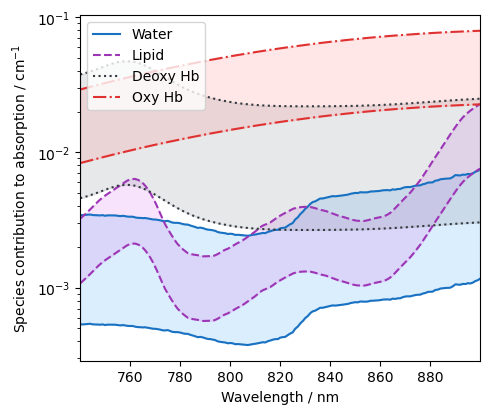

In [10]:
from constants.colors import colors 

wl_mask = (740 < wls) & (wls < 900)
limited_wls = wls[wl_mask]

props = ['water_abs', 'lipid_abs', 'deoxy_abs', 'oxy_abs']
prop_colors = ['blue', 'grape', 'gray', 'red']
labels = ['Water', 'Lipid', 'Deoxy Hb', 'Oxy Hb']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
strengths = [0, 0, 2, 0, 0]

fig = plt.figure(figsize=(5, 4.25))
for prop, color, strength in zip(props, prop_colors, strengths):
    abs = np.array(prior['prior'][prop][0, :, wl_mask])
    mean = np.mean(abs, axis=0)
    std = np.std(abs, axis=0)
    plt.fill_between(limited_wls, mean - std, mean + std, color=colors[color][4+strength], alpha=0.2)

for prop, color, label, linestyle in zip(props, prop_colors, labels, linestyles):
    abs = np.array(prior['prior'][prop][0, :, wl_mask])
    mean = np.mean(abs, axis=0)
    std = np.std(abs, axis=0)
    #plt.plot(limited_wls, mean, colors[color][8])
    plt.plot(limited_wls, mean + std, colors[color][8], linestyle=linestyle, label=label)
    plt.plot(limited_wls, mean - std, colors[color][8], linestyle=linestyle)

plt.xlim((min(limited_wls), max(limited_wls)))
plt.yscale('log')

plt.xlabel('Wavelength / nm')
plt.ylabel(r'Species contribution to absorption / cm$^{-1}$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./figure_generation/figures/absorption_contribution_ranges.png', dpi=fig.dpi, transparent=True, bbox_inches = "tight")
plt.savefig('./figure_generation/figures/absorption_contribution_ranges.pdf', dpi=fig.dpi, transparent=True, bbox_inches = "tight")
plt.show()

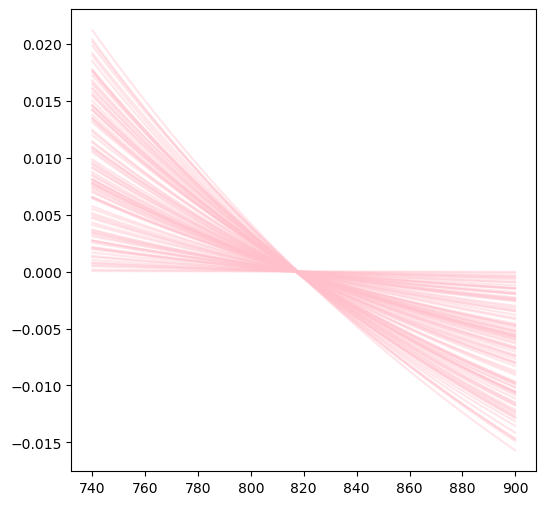

In [7]:
# error in ignoring melanin

plt.figure(figsize=(6,6))

L = 0.02

for i in prior['prior'].draw:
    mel_abs = prior['prior'].mel_abs[0, i, :]
    diff = mel_abs - np.mean(mel_abs)
    error = diff*L
    plt.plot(wls, error, color='pink', alpha=0.4)

plt.show()